**Implementation of custom convolutional layer.**

Goals:

*   Enchance my understanding of convolutional neural networks. 
*   Build layer as simple as possible (using numpy)
*   Make layer compatible with tf.keras models.
*   Make sure layer can be trained

I've picked common spatial 2D layer, and I will be testing it on image classification tasks.

First I needed to recollect the structure of custom layers for tf.keras. From tensorflow documentation:

 *The best way to implement your own layer is extending the tf.keras.Layer class and implementing:*

*   init , where you can do all input-independent initialization
*   build, where you know the shapes of the input tensors and can do the rest of the initialization
*   call, where you do the forward computation

Note. Learning part (gradients, backpropagation) tf.keras handles itself. When writing custom layers, you should mostly worry about forward calculations.


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_images(images, labels=[], cmap=None, n_cols=5, figsize=(12,8)):
  """
  Plots an array of images. Optionally could display labels.
  """
  n = len(images)
  n_rows = n // n_cols + 1
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    if len(labels):
      plt.title(label_names[int(labels[i])])

### Initial implementation. (Numpy + "for loops")


First plan was to write code as simple as possible, not caring about performance and elegancy. Also I've borrowed parameter names from keras implementation of tf.keras.layers.Conv2D for simplicity

So I looped over images in batch, then filters (layer kernels), then over single image (horizontally and vertically) and made dot product of perception field (small window of image) and kernel. Then appended all results in lists.
This was a slow method :) 

But the good thing it sort of worked. Not with keras models, but filters were applied correctly.

I've started to modify it right away, so I'm not showing the initial code.
The slowest part was obviously looping over image, so I found good implementation of this algorithm - skimage.util.shape.view_as_windows.

In [3]:
from skimage.util.shape import view_as_windows

class initial_MyConv2dLayer(keras.layers.Layer):
  def __init__(self, filters, kernel_size, strides=(1,1),
               activation=None, kernel_initializer='glorot_uniform', 
               bias_initializer='zeros', **kwargs):
    
    # pass arguments to parent class
    super().__init__(**kwargs)
    self.filters = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.activation = keras.activations.get(activation)
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer

  def build(self, batch_input_shape):
    self.input_channels = batch_input_shape[-1]
    # Initialize weights
    self.kernels = (self.add_weight(name="kernels",
                       shape=[self.filters] + [self.kernel_size[0]] + [self.kernel_size[1]] + [self.input_channels],
                       initializer=self.kernel_initializer))
    self.bias = self.add_weight(name="bias",
                                  shape=self.filters,
                                  initializer=self.bias_initializer)

  def call(self, X):
    images_feature_maps = []
    for image in X:
      feature_maps = []
      for filter_index in range(self.filters):
        # Creates array of perception fields (small images) of kernel_size shape
        image_slices = view_as_windows(image, 
          (self.kernel_size[0], self.kernel_size[1], self.input_channels),
          step=(self.strides[0], self.strides[1], 1))
        # Reshaping for dot product (to avoid looping over perception fields)
        image_slices_vectorized = image_slices.reshape(
            image_slices.shape[0] * image_slices.shape[1], self.kernel_size[0], 
            self.kernel_size[1], self.input_channels)

        dot_product = image_slices_vectorized @ self.kernels[filter_index] + self.bias[filter_index]
        # Counting mean value of resulted kernel shape dot products 
        filtered_image = tf.reshape(tf.reduce_sum(dot_product,
                      axis=(1,2,3)), (image_slices.shape[0], image_slices.shape[1]))    
        feature_maps.append(filtered_image)
      images_feature_maps.append(np.array(feature_maps))
    return np.array(images_feature_maps)

Thank to "for loops" you can see clearly what this layers does. But it's very slow and not compatible with tf.keras

### Applying randomly initialized filters to sample images

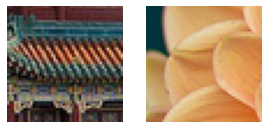

In [6]:
from sklearn.datasets import load_sample_image
# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
images = np.array([china, flower])

# cut images to speed up process (since algorithm is very slow)
part_images = images[:, 150:200, 180:230, :]

plot_images(part_images)

In [7]:
my_conv = initial_MyConv2dLayer(10, (3,3))
my_conv.build(part_images.shape)
filtered_images = my_conv.call(part_images)
# Note - using valid padding, so edge pixels is lost
filtered_images.shape

(2, 10, 48, 48)

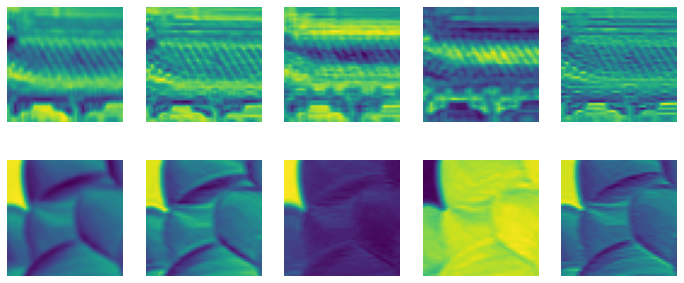

In [8]:
# Take 5 filters from each image
feature_maps = np.vstack((filtered_images[0,0:5], filtered_images[1,0:5]))
# Randomly initialized filters
plot_images(feature_maps)

### Implementation using tensorflow functions
For better compatibility with tf.keras models


Now I will rewrite "call" method using tf functions. This would also require to change shapes of the kernels in "build" method. 

Also I added some hyperparameters and get_config method (for saving models)

Note. I tried to use @tf.function wrapper but there was no time improvements

In [9]:
class MyConv2dLayer(keras.layers.Layer):
  """
  Performs 2D spatial convolution over batch of images.
  Data format must be "channels last".
  Parameters are equivalent to keras.layers.Conv2D class.
  """
  def __init__(self, filters, kernel_size=(3,3), strides=(1,1), padding="valid",
               activation=None, use_bias=True, 
               kernel_initializer='glorot_uniform', bias_initializer='zeros', 
               **kwargs):
    super().__init__(**kwargs)
    self.filters = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.padding = padding
    self.activation = keras.activations.get(activation)
    self.use_bias = use_bias
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
  
  def build(self, batch_input_shape):
    self.input_channels = batch_input_shape[-1]

    self.kernels = (self.add_weight(name="kernels",
                       shape=[self.kernel_size[0] * self.kernel_size[1] * self.input_channels] + [self.filters],
                       initializer=self.kernel_initializer))
    if self.use_bias:
      self.bias = self.add_weight(name="bias",
                                    shape=self.filters,
                                    initializer=self.bias_initializer)
    super().build(batch_input_shape)
  
  def call(self, X):
    image_slices = tf.image.extract_patches(X, 
              (1,self.kernel_size[0], self.kernel_size[1],1), 
              strides=[1, self.strides[0], self.strides[1],1], 
              rates=[1,1,1,1], padding=self.padding.upper())
    image_slices = tf.cast(image_slices, tf.float32)
    dot_product = image_slices @ self.kernels
    if self.use_bias:
      dot_product += self.bias
    return self.activation(dot_product)

  def get_config(self):
    base_config = super().get_config()
    return {**base_config, 
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "padding": self.padding,
            "use_bias": self.use_bias,
            "kernel_initializer": self.kernel_initializer,
            "bias_initializer": self.bias_initializer,
            "activation": keras.activations.serialize(self.activation)}

## Testing on cifar10 dataset
I will compare two models. One will have convolutional layers with my implementation and other tf.keras.layers.Conv2D.

In [10]:
data = keras.datasets.cifar10.load_data()

(X_train_val, y_train_val), (X_test, y_test) = data

X_train, y_train = X_train_val[:40000] / 255, y_train_val[:40000]
X_valid, y_valid = X_train_val[40000:] / 255, y_train_val[40000:]
X_test = X_test / 255

label_names = ["airplane", "automobile", "bird", "cat",	"deer", "dog", "frog", "horse",	"ship",	"truck"]
X_train.shape, y_train.shape, X_valid.shape

((40000, 32, 32, 3), (40000, 1), (10000, 32, 32, 3))

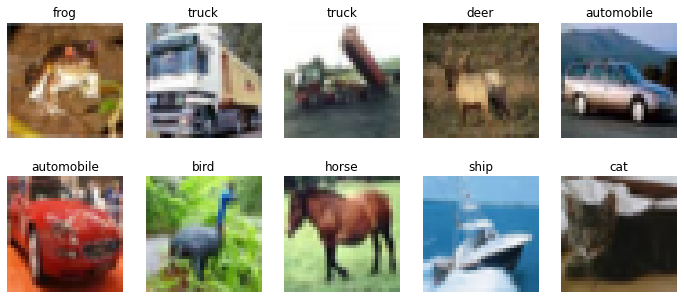

In [11]:
plot_images(X_train[0:10], y_train[0:10])

In [12]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=5)

### Simple model that uses my convolutional layers

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

myconv_model = keras.models.Sequential([
    MyConv2dLayer(32, (3,3), padding="valid", activation="relu"),
    MyConv2dLayer(64, (3,3), padding="valid", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

myconv_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

my_history = myconv_model.fit(X_train, y_train, batch_size=32, epochs=30, 
                           validation_data=(X_valid, y_valid),
                           callbacks=early_stop_cb)

Epoch 1/30
1250/1250 [==============================] - 22s 18ms/step - loss: 1.6936 - accuracy: 0.3785 - val_loss: 1.2823 - val_accuracy: 0.5541
Epoch 2/30
1250/1250 [==============================] - 22s 18ms/step - loss: 1.3224 - accuracy: 0.5249 - val_loss: 1.0975 - val_accuracy: 0.6162
Epoch 3/30
1250/1250 [==============================] - 22s 18ms/step - loss: 1.1705 - accuracy: 0.5812 - val_loss: 1.0138 - val_accuracy: 0.6490
Epoch 4/30
1250/1250 [==============================] - 22s 17ms/step - loss: 1.0663 - accuracy: 0.6224 - val_loss: 1.0006 - val_accuracy: 0.6513
Epoch 5/30
1250/1250 [==============================] - 22s 18ms/step - loss: 0.9896 - accuracy: 0.6503 - val_loss: 0.9241 - val_accuracy: 0.6811
Epoch 6/30
1250/1250 [==============================] - 22s 17ms/step - loss: 0.9149 - accuracy: 0.6750 - val_loss: 0.9202 - val_accuracy: 0.6754
Epoch 7/30
1250/1250 [==============================] - 22s 17ms/step - loss: 0.8370 - accuracy: 0.7031 - val_loss: 0.8943 -

### Using same model architechure but with keras convolutional layers (same params)

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), padding="valid", activation="relu"),
    keras.layers.Conv2D(64, (3,3), padding="valid", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

base_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

base_history = base_model.fit(X_train, y_train, batch_size=32, epochs=30, 
                           validation_data=(X_valid, y_valid),
                           callbacks=early_stop_cb)

Epoch 1/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.5993 - accuracy: 0.4191 - val_loss: 1.2198 - val_accuracy: 0.5688
Epoch 2/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.2536 - accuracy: 0.5540 - val_loss: 1.0610 - val_accuracy: 0.6320
Epoch 3/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.1158 - accuracy: 0.6033 - val_loss: 0.9870 - val_accuracy: 0.6540
Epoch 4/30
1250/1250 [==============================] - 13s 10ms/step - loss: 1.0190 - accuracy: 0.6380 - val_loss: 0.9444 - val_accuracy: 0.6651
Epoch 5/30
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9475 - accuracy: 0.6642 - val_loss: 0.9042 - val_accuracy: 0.6844
Epoch 6/30
1250/1250 [==============================] - 13s 10ms/step - loss: 0.8884 - accuracy: 0.6857 - val_loss: 0.9056 - val_accuracy: 0.6820
Epoch 7/30
1250/1250 [==============================] - 13s 10ms/step - loss: 0.8279 - accuracy: 0.7054 - val_loss: 0.8840 -

# Conclusions
Plus plotting models training histories

Looking at the training time we could clearly see that my implementation is much slower, but making it as fast as tensorflow wasn't in initial goals. 

Good thing that layer is pretty compact and not complicated (as long as you aware of shapes of batches, slices and kernels). And I definetly learned a lot about TF when tried to convert my initial model to become compatible with it. 

Finally let's look at the learning curves. As you can see they are pretty close, which means that models are learning similarly.

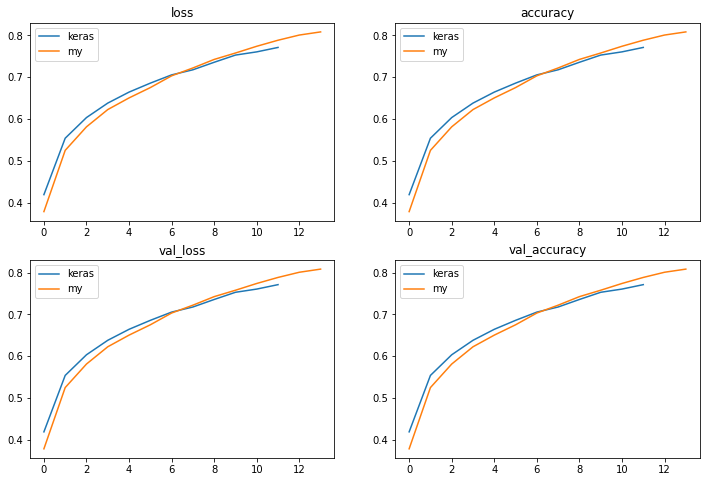

In [15]:
plt.figure(figsize=(12,8))
for i, key in enumerate(base_history.history.keys()):
  plt.subplot(2, 2, i+1)
  plt.plot(base_history.history["accuracy"], label="keras")
  plt.plot(my_history.history["accuracy"], label="my")
  plt.legend()
  plt.title(key)
# Note. Early stopping callback may stop one model earlier